In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## 1. Load clean data

In [2]:
# Load clean data
X_test_student = pd.read_csv('X_test_student.csv', index_col=0)
X_train_student = pd.read_csv('X_train_student.csv', index_col=0)
X_test_worker = pd.read_csv('X_test_worker.csv', index_col=0)
X_train_worker = pd.read_csv('X_train_worker.csv', index_col=0)

y_test_student = pd.read_csv('y_test_student.csv').squeeze()
y_train_student = pd.read_csv('y_train_student.csv').squeeze()
y_test_worker = pd.read_csv('y_test_worker.csv').squeeze()
y_train_worker = pd.read_csv('y_train_worker.csv').squeeze()

print(f'Dataset shape: {X_train_student.shape}')
print(f'\nColumns: {X_train_student.columns.tolist()}')
print(f'\nData types:\n{X_train_student.dtypes}')
print(f'\nMissing values:\n{X_train_student.isnull().sum()}')
print(f'\nFirst few rows:')
X_train_student.head()

Dataset shape: (26488, 17)

Columns: ['Name', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness']

Data types:
Name                                      object
Gender                                    object
Age                                        int64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                              int64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                           int64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever 

,Name,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,
58555,Rupak,Male,26,Lucknow,Student,4.0,0,9.72,4.0,0,6-8 hours,Unhealthy,Bachelor,1,12,2.0,1
89195,Aarav,Male,33,Srinagar,Student,5.0,0,5.37,5.0,0,Less than or equal 6 hours,Healthy,Master,0,8,2.0,0
82705,Ishita,Female,25,Patna,Student,4.0,0,5.32,1.0,0,Less than or equal 6 hours,Unhealthy,Bachelor,1,11,4.0,1
50848,Tanmay,Male,25,Lucknow,Student,5.0,0,8.74,3.0,0,Less than or equal 6 hours,Healthy,Bachelor,1,2,4.0,0
28446,Armaan,Male,29,Chennai,Student,5.0,0,8.44,1.0,0,Less than or equal 6 hours,Unhealthy,Bachelor,1,12,4.0,1


In [3]:
X_train_worker.head()

,Name,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,
16511,Siddhesh,Male,58,Jaipur,Business/Finance,0,2.0,0,0,1.0,Less than or equal 6 hours,Unhealthy,Master,0,7,5.0,1
143292,Siddharth,Female,47,Rajkot,Creative/Media,0,2.0,0,0,5.0,Less than or equal 6 hours,Moderate,Bachelor,0,11,2.0,0
60623,Aarohi,Female,35,Kanpur,Engineering/Architecture,0,3.0,0,0,5.0,Less than or equal 6 hours,Healthy,Bachelor,0,11,1.0,1
118846,Riya,Female,55,Bangalore,Business/Finance,0,4.0,0,0,1.0,6-8 hours,Moderate,Master,0,9,3.0,0
122203,Riya,Female,54,Ludhiana,Education/Research,0,5.0,0,0,1.0,More than 8 hours,Healthy,Master,1,10,3.0,1


In [4]:
binary_cols = ['Depression', 
               'Have you ever had suicidal thoughts ?',
               'Family History of Mental Illness']

ordinal_cols = ['Sleep Duration', 'Dietary Habits']

#numeric_cols = ['Age', 'CGPA', 'Work/Study Hours']

categorical_cols = ['Gender', 'Profession', 'Degree']

high_card_cols = ['City']

## 2.  Categorical feature encoding

Categorical columns:

- Gender (Male / Female / Other): 3 distinct categories, no meaningful ordinal relationship

- Profession (10 unique categories): multi-class nominal feature with no natural hierarchical structure.

- Degree (7 unique categories): although educational levels may appear ordered, in this dataset the categories do not follow a strict or consistent hierarchy.

=> Using OneHotEncoder

- Sleep Duration (3 ordered categories): 'Less than or equal 6 hours' < '6-8 hours' < 'More than 8 hours'

- Dietary Habits (3 ordered categories): 'Unhealthy' < 'Moderate'  < 'Healthy'

=> Using OrdinalEncoder

- City (high cardinality categorical feature)

=> Using Frequency encoding

In [5]:

from sklearn.base import BaseEstimator, TransformerMixin

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps = {}


    def fit(self, X, y=None):
        for col in X.columns:
            self.freq_maps[col] = X[col].value_counts(normalize=True).to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            X_transformed[col] = X_transformed[col].map(self.freq_maps[col]).fillna(0)
        return X_transformed

In [6]:
def encode_categorical_features(X_train, X_test, categorical_cols, high_card_cols, ordinal_cols):

    categorical_cols = [
        col for col in categorical_cols 
        if X_train[col].nunique() > 1
    ]   
    
    ordinal_maps = [
    ['Less than or equal 6 hours', '6-8 hours', 'More than 8 hours'],  # Sleep Duration
    ['Unhealthy', 'Moderate', 'Healthy']   # Dietary Habits
    ]  
    ordinal_pipeline = Pipeline([ 
        ('ordinal', OrdinalEncoder(categories=ordinal_maps)) 
    ])
    
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])

    high_card_pipeline = Pipeline([
        ('freq', FrequencyEncoder())
    ])

    preprocessor = ColumnTransformer([
        ('ordinal', ordinal_pipeline, ordinal_cols),
        ('low_card', categorical_pipeline, categorical_cols),
        ('high_card', high_card_pipeline, high_card_cols)
    ], remainder='passthrough')

    X_train_encoded = preprocessor.fit_transform(X_train)
    X_test_encoded = preprocessor.transform(X_test)

    ordinal_names = ordinal_cols 
    onehot_names = preprocessor.named_transformers_['low_card']['onehot'].get_feature_names_out(categorical_cols) 
    passthrough_cols = [col for col in X_train.columns if col not in ordinal_cols + categorical_cols + high_card_cols] 
    feature_names = list(ordinal_names) + list(onehot_names) + list(high_card_cols) + passthrough_cols
    
    X_train_new = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
    X_test_new = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)
    
    return X_train_new, X_test_new

In [7]:
X_train_student, X_test_student = encode_categorical_features(X_train_student, X_test_student, categorical_cols, high_card_cols, ordinal_cols)
X_train_student.head()

,Sleep Duration,Dietary Habits,Gender_Female,Gender_Male,Gender_Other,Degree_Bachelor,Degree_Doctorate,Degree_High School,Degree_Master,City,...,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,,,,
58555,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.041453,...,Student,4.0,0,9.72,4.0,0,1,12,2.0,1
89195,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.049003,...,Student,5.0,0,5.37,5.0,0,0,8,2.0,0
82705,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.03662,...,Student,4.0,0,5.32,1.0,0,1,11,4.0,1
50848,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.041453,...,Student,5.0,0,8.74,3.0,0,1,2,4.0,0
28446,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.030655,...,Student,5.0,0,8.44,1.0,0,1,12,4.0,1


With student dataset drop columns: Name, Profession

In [8]:
columns_to_drop = ["Name", "Profession"]
X_train_student.drop(columns_to_drop, axis=1, inplace=True)
X_test_student.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
X_train_worker, X_test_worker = encode_categorical_features(X_train_worker, X_test_worker, categorical_cols, high_card_cols, ordinal_cols)
X_train_worker.head()

,Sleep Duration,Dietary Habits,Gender_Female,Gender_Male,Gender_Other,Profession_Business/Finance,Profession_Creative/Media,Profession_Education/Research,Profession_Engineering/Architecture,Profession_Legal,...,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness
id,,,,,,,,,,,,,,,,,,,,,
16511,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,58,0,2.0,0,0,1.0,0,7,5.0,1
143292,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,47,0,2.0,0,0,5.0,0,11,2.0,0
60623,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,35,0,3.0,0,0,5.0,0,11,1.0,1
118846,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,55,0,4.0,0,0,1.0,0,9,3.0,0
122203,2.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,54,0,5.0,0,0,1.0,1,10,3.0,1


With dataset for worker drop columns: Name

In [10]:
columns_to_drop = ["Name"]
X_train_worker.drop(columns_to_drop, axis=1, inplace=True)
X_test_worker.drop(columns_to_drop, axis=1, inplace=True)

In [11]:
def fix_numeric_types(df):
    df = df.copy()
    numeric_cols = df.columns  # ép tất cả, column nào không thể ép sẽ thành NaN
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df


## 3. Create new features and interactions

### 3.1. Create new features and interactions for student data

- Burnout_Load = Academic Pressure × Work/Study Hours -> áp lực học lớn + nhiều giờ học -> overload, nhưng áp lực học lớn + ít giờ học -> thiếu động lực -> stress do yếu tố khác 

- Effort_Reward_Imbalance = Burnout_load x (6 - Study Satisfaction) -> nguy cơ trầm cảm tăng nếu như high effort, low satisfaction

- Performance_Anxiety_Score = CGPA x Academic Pressure -> CGPA thấp mà áp lực cao → depression risk rất lớn, CGPA cao mà áp lực cao → nhóm “perfectionist” → also risky

### 3.2. Create new features and interactions for worker data

Burnout_Load = Work Pressure × Work/Study Hours: áp lực công việc + nhiều giờ làm -> nguy cơ overload

Effort_Reward_Imbalance = Burnout_load x (6 - Job Satisfaction) -> nguy cơ trầm cảm tăng nếu như high effort, low satisfaction

Trapped_Score = Financial Stress + (6 - Job Satisfaction) -> vấn đề tài chính + chán công việc -> không thể nghỉ việc, mà vẫn kẹt đó. 

### 3.3. Create new features and interactions for all

- Physical Health = Sleep Hours x Dietarity Habits -> Ngủ đủ giấc, ăn uống lành mạnh/ ngủ thiếu giờ + unhealthy: sức khỏe thể chất có ảnh hưởng tới sức khỏe tinh thần ko?

- Work_Sleep = Work/Study Hours x Sleep Hours -> ngủ ít học nhiều dẫn tới burning out, trầm cảm

- Suicidal Thoughts x Family Mental History -> suy nghĩ tự tử + tiền sử gia đình có gây ra trầm cảm 

- Sleep_Vulnerability = Financial Stress x Sleep Hours -> căng thẳng tài chính -> lo lắng, ngủ ít

- Financial Stress x Work/ Study Hours: stress tài chính-> làm/ nhiều giờ hơn để sau có tương lai tốt...

- Age_Pressure = Pressure / Age -> người trẻ thường dễ bị áp lực hơn so với lớn tuổi hơn

In [12]:
# 4.1. Create new features and interactions for student data
def create_student_features(df):
    df = df.copy()
    # Burnout_Load = Academic Pressure * Work/Study Hours
    df['Burnout_Load'] = df['Academic Pressure'] * df['Work/Study Hours']
    
    # Effort_Reward_Imbalance = Burnout_Load * (6 - Study Satisfaction)
    df['Effort_Reward_Imbalance'] = df['Burnout_Load'] * (6 - df['Study Satisfaction'])
    
    # Performance_Anxiety_Score = CGPA * Academic Pressure
    df['Performance_Anxiety_Score'] = df['CGPA'] * df['Academic Pressure']
    
    return df

# 4.2. Create new features and interactions for worker data
def create_worker_features(df):
    df = df.copy()
    # Burnout_Load = Work Pressure * Work/Study Hours
    df['Burnout_Load'] = df['Work Pressure'] * df['Work/Study Hours']
    
    # Effort_Reward_Imbalance = Burnout_Load * (6 - Job Satisfaction)
    df['Effort_Reward_Imbalance'] = df['Burnout_Load'] * (6 - df['Job Satisfaction'])
    
    # Trapped_Score = Financial Stress + (6 - Job Satisfaction)
    df['Trapped_Score'] = df['Financial Stress'] + (6 - df['Job Satisfaction'])
    
    return df

# 4.3. Create new features and interactions for all
def create_common_features(df, is_student=True):
    df = df.copy()
    # Physical Health = Sleep Duration * Dietary Habits
    df['Physical_Health'] = df['Sleep Duration'] * df['Dietary Habits']
    
    # Work_Sleep = Work/Study Hours * Sleep Duration
    df['Work_Sleep'] = df['Work/Study Hours'] * df['Sleep Duration']
    
    # Suicidal Thoughts * Family Mental History
    df['Suicidal_Family_Interaction'] = df['Have you ever had suicidal thoughts ?'] * df['Family History of Mental Illness']
    
    # Sleep_Vulnerability = Financial Stress * Sleep Duration
    df['Sleep_Vulnerability'] = df['Financial Stress'] * df['Sleep Duration']
    
    # Financial Stress * Work/ Study Hours
    df['Financial_Work_Interaction'] = df['Financial Stress'] * df['Work/Study Hours']
    
    # Age_Pressure = Pressure / Age
    # Adding 5 to Age to avoid division by zero and sign flipping issues near mean
    if is_student:
        df['Age_Pressure'] = df['Academic Pressure'] / (df['Age'] + 5)
    else:
        df['Age_Pressure'] = df['Work Pressure'] / (df['Age'] + 5)
        
    return df

# Apply features
X_train_student = fix_numeric_types(X_train_student)
X_test_student = fix_numeric_types(X_test_student)

X_train_student = create_student_features(X_train_student)
X_train_student = create_common_features(X_train_student, is_student=True)

X_test_student = create_student_features(X_test_student)
X_test_student = create_common_features(X_test_student, is_student=True)

X_train_worker = fix_numeric_types(X_train_worker)
X_test_worker  = fix_numeric_types(X_test_worker)

X_train_worker = create_worker_features(X_train_worker)
X_train_worker = create_common_features(X_train_worker, is_student=False)

X_test_worker = create_worker_features(X_test_worker)
X_test_worker = create_common_features(X_test_worker, is_student=False)

print("Features created successfully.")


Features created successfully.


## 4. Numeric features scaling

Scale numerical columns using StandardScaler 

In [13]:
numeric_cols_student = X_train_student.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols_worker  = X_train_worker.select_dtypes(include=['int64','float64']).columns.tolist()

In [14]:
print("Student numeric:", numeric_cols_student)
print("Worker numeric:", numeric_cols_worker)


Student numeric: ['Sleep Duration', 'Dietary Habits', 'Gender_Female', 'Gender_Male', 'Gender_Other', 'Degree_Bachelor', 'Degree_Doctorate', 'Degree_High School', 'Degree_Master', 'City', 'Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Burnout_Load', 'Effort_Reward_Imbalance', 'Performance_Anxiety_Score', 'Physical_Health', 'Work_Sleep', 'Suicidal_Family_Interaction', 'Sleep_Vulnerability', 'Financial_Work_Interaction', 'Age_Pressure']
Worker numeric: ['Sleep Duration', 'Dietary Habits', 'Gender_Female', 'Gender_Male', 'Gender_Other', 'Profession_Business/Finance', 'Profession_Creative/Media', 'Profession_Education/Research', 'Profession_Engineering/Architecture', 'Profession_Legal', 'Profession_Medical/Health', 'Profession_Other Professions', 'Profession_Service/Operations', 'Profession_Tech/IT', 'Degree_Bachelor', 'Degree

In [15]:
def scale_data(X_train, X_test, numeric_cols):
    scaler = StandardScaler()

    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    return X_train, X_test

In [16]:
X_train_student, X_test_student = scale_data(
    X_train_student, X_test_student, numeric_cols_student
)

X_train_worker, X_test_worker = scale_data(
    X_train_worker, X_test_worker, numeric_cols_worker
)


In [17]:
import pandas as pd

# Student
df_student = X_train_student.copy()
df_student['Depression'] = y_train_student.values  # chắc chắn cùng index

# Worker
df_worker = X_train_worker.copy()
df_worker['Depression'] = y_train_worker.values

In [18]:
X_train_student.head()

,Sleep Duration,Dietary Habits,Gender_Female,Gender_Male,Gender_Other,Degree_Bachelor,Degree_Doctorate,Degree_High School,Degree_Master,City,...,Family History of Mental Illness,Burnout_Load,Effort_Reward_Imbalance,Performance_Anxiety_Score,Physical_Health,Work_Sleep,Suicidal_Family_Interaction,Sleep_Vulnerability,Financial_Work_Interaction,Age_Pressure
id,,,,,,,,,,,,,,,,,,,,,
58555,0.374591,-1.124721,-0.891188,0.897684,-0.059995,1.151502,-0.137144,-0.52744,-0.708108,0.582742,...,1.039672,1.517554,0.355326,1.286444,-0.558493,1.040307,1.490635,-0.065660,0.067763,0.471470
89195,-0.869567,1.384575,-0.891188,0.897684,-0.059995,-0.868431,-0.137144,-0.52744,1.412214,1.377654,...,-0.961842,1.032381,-0.482812,0.246777,-0.558493,-0.720269,-0.670855,-0.746366,-0.410191,0.521710
82705,-0.869567,-1.124721,1.122098,-1.113978,-0.059995,1.151502,-0.137144,-0.52744,-0.708108,0.073998,...,1.039672,1.274968,2.211203,-0.234598,-0.558493,-0.720269,1.490635,-0.746366,1.262646,0.556319
50848,-0.869567,1.384575,-0.891188,0.897684,-0.059995,1.151502,-0.137144,-0.52744,-0.708108,0.582742,...,-0.961842,-0.787019,-0.632480,1.703002,-0.558493,-0.720269,-0.670855,-0.746366,-0.888145,1.213905
28446,-0.869567,-1.124721,-0.891188,0.897684,-0.059995,1.151502,-0.137144,-0.52744,-0.708108,-0.553982,...,1.039672,2.245315,3.408543,1.573368,-0.558493,-0.720269,1.490635,-0.746366,1.501623,0.827090


## 5. Feature selection

Select features by using:

- Pearson correlation: rank features by absolute linear correlation with target.

- Mutual Information: rank features by non-linear dependency with target.

- VIF: check multicollinearity among features.

- LassoCV: embedded feature selection via regularized linear regression coefficients.

- RandomForest importance: rank features by contribution to tree-based model predictions.

- Aggregate ranking: combine ranks from all methods to get mean rank.

Select top features: choose top 10 features based on aggregated ranking.


In [19]:
# %pip install statsmodels

In [20]:
# VIF helper (uses statsmodels if available)
def compute_vif(df, features):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X = df[features].assign(constant=1.0)
    vif_data = {f: variance_inflation_factor(X.values, i) for i, f in enumerate(X.columns) if f != 'constant'}
    return pd.Series(vif_data).sort_values(ascending=False)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def feature_selection(X_train, y_train):
    # Pearson correlation with target (absolute)
    corrs = X_train.corrwith(y_train).abs().sort_values(ascending=False)
    print('\nTop 15 features by abs(correlation) with target:')
    print(corrs.head(15))

    # Mutual Information (captures non-linear relationships)
    mi = mutual_info_classif(X_train.fillna(0), y_train)
    mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
    print('\nTop 15 features by mutual information:')
    print(mi_series.head(15))

    # VIF (optional - requires statsmodels)
    vif = compute_vif(X_train.fillna(0), X_train.columns.tolist())
    if vif is not None:
        print('\nTop VIF values:')
        print(vif.sort_values(ascending=True).head(15))

    # LassoCV for embedded selection
    lasso = LassoCV(cv=5, random_state=42, n_jobs=-1)
    lasso.fit(X_train.fillna(0), y_train)
    coef_abs = pd.Series(np.abs(lasso.coef_), index=X_train.columns).sort_values(ascending=False)
    print('\nTop 15 features by absolute Lasso coefficients:')
    print(coef_abs.head(15))

    # RandomForest importance
    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf.fit(X_train.fillna(0), y_train)
    rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print('\nTop 15 features by RandomForest importance:')
    print(rf_imp.head(15))

    # Aggregate a simple ranking (average rank across methods)
    rank_df = pd.DataFrame({
        'corr_rank': corrs.rank(ascending=False),
        'mi_rank': mi_series.rank(ascending=False),
        'lasso_rank': coef_abs.rank(ascending=False),
        'rf_rank': rf_imp.rank(ascending=False)
    }).fillna(1e6) # missing treated as low importance

    rank_df['mean_rank'] = rank_df.mean(axis=1)
    ranked = rank_df.sort_values('mean_rank')

    print('\nTop 20 features by aggregated mean rank:')
    print(ranked.head(20))

    # Save selected top features
    selected_features = ranked.head(10).index.tolist()
    print('\nSelected features (top 10):', selected_features)
    return selected_features


In [22]:
student_features = feature_selection(X_train_student, y_train_student)

/root/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]

Top 15 features by abs(correlation) with target:
Gender_Male                              0.039987
Gender_Female                            0.039987
Effort_Reward_Imbalance                  0.031796
Age                                      0.031706
Age_Pressure                             0.030657
Performance_Anxiety_Score                0.028265
Burnout_Load                             0.027119
CGPA                                     0.022262
Academic Pressure                        0.021002
Have you ever had suicidal thoughts ?    0.017549
Study Satisfaction                       0.015222
Work/Study Hours                         0.013170
Suicidal_Family_Interaction              0.011800
Fina

In [23]:
worker_features = feature_selection(X_train_worker, y_train_worker)

/root/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/root/venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]

Top 15 features by abs(correlation) with target:
Effort_Reward_Imbalance             0.007717
City                                0.007500
Degree_Bachelor                     0.007445
Degree_Master                       0.007307
Job Satisfaction                    0.007004
Family History of Mental Illness    0.006480
Work/Study Hours                    0.006248
Burnout_Load                        0.005893
Profession_Business/Finance         0.004634
Suicidal_Family_Interaction         0.004514
Profession_Legal                    0.004502
Financial Stress                    0.003858
Age                                 0.003785
Financial_Work_Interaction          0.003768
Profession_Medical/Healt

In [24]:
# This code is temporary
X_train_student = X_train_student[student_features]
X_test_student = X_test_student[student_features]
X_train_worker = X_train_worker[worker_features]
X_test_worker = X_test_worker[worker_features]

student_model = RandomForestClassifier(random_state=42)
worker_model = RandomForestClassifier(random_state=42)

student_model.fit(X_train_student, y_train_student)
worker_model.fit(X_train_worker, y_train_worker)
y_pred_student = student_model.predict(X_test_student)
y_pred_worker = worker_model.predict(X_test_worker)

Classification Report for Student MODEL
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      2744
           1       0.88      0.89      0.88      3879

    accuracy                           0.86      6623
   macro avg       0.86      0.86      0.86      6623
weighted avg       0.86      0.86      0.86      6623



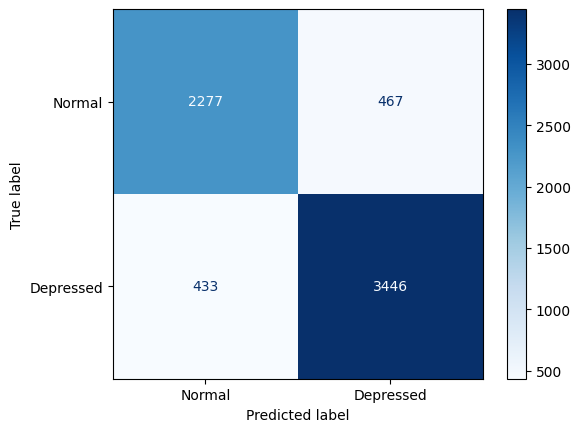

In [25]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Classification Report for Student MODEL")
print(classification_report(y_test_student, y_pred_student))

# Vẽ ma trận
ConfusionMatrixDisplay.from_predictions(y_test_student, y_pred_student, display_labels=["Normal", "Depressed"], cmap="Blues")
plt.show()


Classification Report for Worker MODEL
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     24489
           1       0.76      0.70      0.73      2195

    accuracy                           0.96     26684
   macro avg       0.87      0.84      0.85     26684
weighted avg       0.96      0.96      0.96     26684



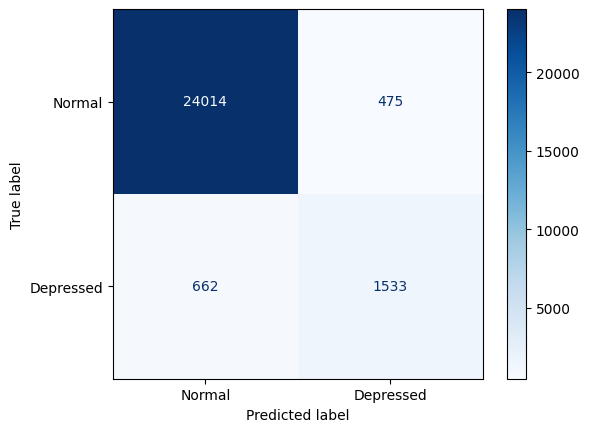

In [26]:
print("Classification Report for Worker MODEL")
print(classification_report(y_test_worker, y_pred_worker))

# Vẽ ma trận
ConfusionMatrixDisplay.from_predictions(y_test_worker, y_pred_worker, display_labels=["Normal", "Depressed"], cmap="Blues")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6527928-bbf4-4c9a-8760-1f30ce0e5ba3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>